In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import time
import random
import shutil

import torch
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes

# Field Selection (False Positives)

In [2]:
def field_selection(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # converted to hsv
    image_shape = img.shape
    img_area = int(image_shape[0] * image_shape[1])

    lower_green = np.array([15, 50, 50])  # lower bound of green
    upper_green = np.array([70, 255, 255])  # upper bound of green
    mask = cv2.inRange(hsv, lower_green, upper_green)  # creates a mask where pixels within the range are white and others are black

    mask = cv2.GaussianBlur(mask, (7, 7), cv2.BORDER_DEFAULT)  # applies a blur

    (contours, _) = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # finds contours, only external ones and only the endpoints

    # check if there are any contours
    if contours:
    # keep track of largest and second largest contours and areas
        max_area = 1
        scd_max_area = 0
        max_index = 0
        scd_max_index = 0

        # find area of contours and keep track of largest and second largest
        for i, contour in enumerate(contours):
            area = cv2.contourArea(contour)
            if area > max_area:
                scd_max_area = max_area
                scd_max_index = max_index
                max_area = area
                max_index = i
            elif area > scd_max_area:
                scd_max_area = area
                scd_max_index = i
        # selects largest contour and computes the convex hull to create a convex polygon
        cnt = contours[max_index]
        hull = cv2.convexHull(cnt)
    else:
        field_in = np.zeros_like(img)
        return field_in

    field_mask = np.zeros((image_shape[0], image_shape[1]))

    # checks if the largest contour is at least 50% of the image, draws it if so
    if max_area > 0.5 * img_area:
        cv2.drawContours(field_mask, [hull], 0, 255, -1)  # draws convex hull on mask, filling it with white (255)
        # checks if second largest contour is at least 10% of the largest contour, draws it if so
        if scd_max_area > 0.3 * max_area:
            cnt = contours[scd_max_index]
            hull = cv2.convexHull(cnt)
            cv2.drawContours(field_mask, [hull], 0, 255, -1)
    else:
        contour_points = np.array([[0, 0], [0, image_shape[0]], [image_shape[1], image_shape[0]], [image_shape[1], 0]])
        cv2.drawContours(field_mask, [contour_points],  0, 255, -1)

    img2 = img.copy()
    cv2.drawContours(img2, [cv2.convexHull(contours[max_index])], -1, (255, 0, 0), 3)
    cv2.drawContours(img2, [cv2.convexHull(contours[scd_max_index])], -1, (0, 255, 0), 3)
    # cv2.drawContours(img2, [contours[max_index]], -1, (0, 0, 255), 3)
    # cv2.drawContours(img2, [contours[scd_max_index]], -1, (0, 0, 0), 3)

    # copies pixels from original image where mask is white
    field_in = np.zeros_like(img)
    field_in[field_mask == 255, :] = img[field_mask == 255, :]

    # same thing but where mask is black
    field_out = np.zeros_like(img) * 255
    field_out[field_mask == 0, :] = img[field_mask == 0, :]
    return field_in, field_mask, img2, mask

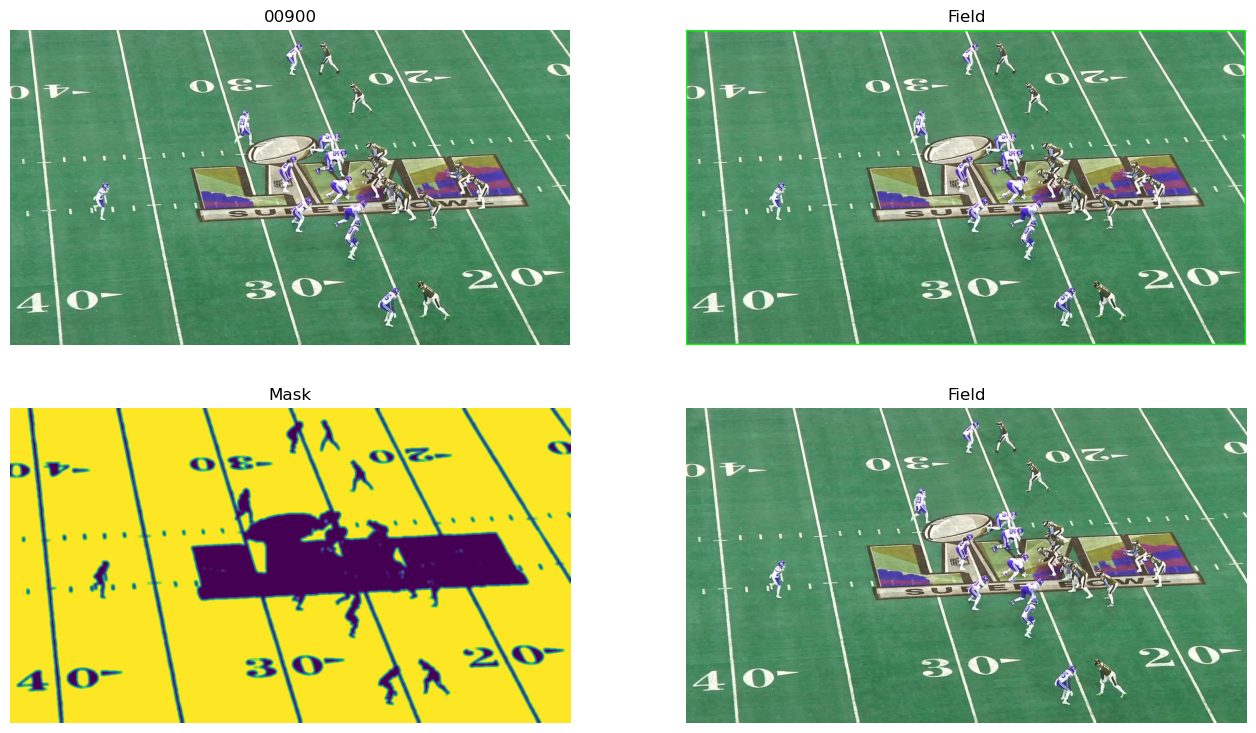

In [3]:
x = str(26).zfill(5)
rand = str(np.random.randint(0, len(os.listdir('frames')))).zfill(5)

img = cv2.imread(f'frames/{x}.jpg')
field_in, field_mask, contours, mask = field_selection(img)

fig, ax = plt.subplots(2, 2, figsize=(16, 9))
ax[0, 0].imshow(img); ax[0, 0].axis('off'); ax[0, 0].set_title(rand)
ax[0, 1].imshow(contours); ax[0, 1].axis('off'); ax[0, 1].set_title('Field')
ax[1, 0].imshow(mask); ax[1, 0].axis('off'); ax[1, 0].set_title('Mask')
ax[1, 1].imshow(field_in); ax[1, 1].axis('off'); ax[1, 1].set_title('Field')

plt.show()

# Player Detection

In [4]:
def player_detection(field_in, ):
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn_v2(weights = weights, box_score_thresh = 0.8)
    model.eval()
    preprocess = weights.transforms()

    img = read_image(field_in)
    img_tensor = preprocess(img).unsqueeze(0)

    with torch.no_grad():   # don't need to calculate gradients as we are doing inference here
        prediction = model(img_tensor)
    boxes = prediction[0]['boxes']
        
    output = img.clone().squeeze(0)
    output = draw_bounding_boxes(img,
                                boxes = prediction[0]['boxes'],
                                colors = "red")
    output

    mean_dim = np.mean(boxes.numpy()[:, 2:] - boxes.numpy()[:, :2], axis = 0)
    avg_bbox_dims = mean_dim[0] * mean_dim[1]
    prop_avg = mean_dim[0] / mean_dim[1]
    
    
    return output, boxes, avg_bbox_dims, prop_avg

In [5]:
field_in = "field_frames/00024.jpg"
output, boxes, avg_bbox_dims, prop_avg = player_detection(field_in)

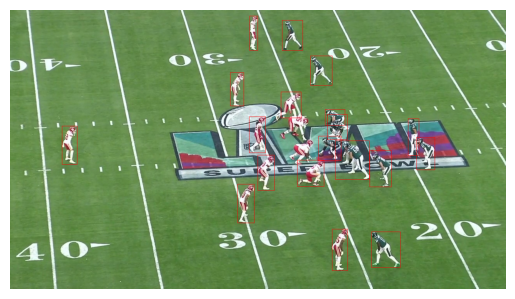

In [6]:
plt.imshow(output.permute(1, 2, 0)); plt.axis('off'); plt.show()

# Blob Detection (False Negatives)

In [159]:
def player_segmentation(img, avg_bbox_dims, prop_avg):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_green = np.array([15,50,50])
    upper_green = np.array([70,255,255])
    mask = cv2.inRange(hsv, lower_green, upper_green)

    contours_ext,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contours,_ = cv2.findContours(mask, cv2.RETR_TREE ,cv2.CHAIN_APPROX_SIMPLE)

    max_w, min_w, max_h, min_h = 150, 5, 150, 5
    detections = []
    n_parts = len(avg_bbox_dims)
    y_list = [i*img.shape[0]/n_parts for i in range(n_parts+1)]

    for c, contour in enumerate(contours):
        x,y,w,h = cv2.boundingRect(contour)
        f = True
        i = 0
        yc = y + h/2
        # segment image into parts
        while f and i < len(y_list):
            if y_list[i] <= yc < y_list[i + 1]:
                f = False
            else:
                i += 1

        # check bounding boxes
        area = w*h
        target_area = avg_bbox_dims[i]
        # print("min_w:", min_w, "w:", w, "max_w:", max_w, "min_h:", min_h, "h:", h, "max_h:", max_h, "target_area:", target_area, "area:", area)
        if min_w < w < max_w and max(min_h, 0.5*w) < h < min(max_h, 5*w) and target_area/4 < area < 1.5 * target_area:
            xc = x + w/2
            yc = y + h/2
            new_h = np.sqrt(target_area * prop_avg)
            new_w = np.sqrt(target_area / prop_avg)
            xmin, xmax, ymin, ymax = max(0, xc - new_w/2), min(img.shape[1], xc + new_w/2), max(0, yc - new_h/2), min(img.shape[0], yc + new_h/2)
            det = [xmin, ymin, xmax, ymax]
            detections.append(det)
    return detections

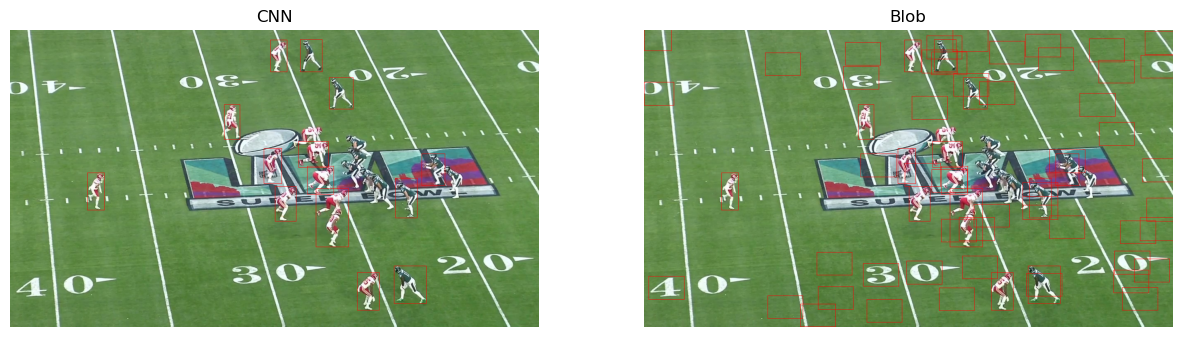

In [236]:
x = "field_frames/00026.jpg"
cnn, boxes, avg_bbox_dims, prop_avg = player_detection(x)
blob = np.array(cnn.permute(1, 2, 0))

detections = player_segmentation(blob, [avg_bbox_dims], prop_avg)
blob = draw_bounding_boxes(cnn,
                            boxes = torch.tensor(detections),
                            colors = "red")

fig, ax = plt.subplots(1, 2, figsize=(15, 9))
ax[0].imshow(cnn.permute(1, 2, 0)); ax[0].axis('off'); ax[0].set_title('CNN')
ax[1].imshow(blob.permute(1, 2, 0)); ax[1].axis('off'); ax[1].set_title('Blob')
plt.show()

In [ ]:
n_im = 10
images = read_image('field_frames/00000.jpg')
field_path = 'field_frames'
path_segs = 0
score_thresh = 0.8
avg_bbox_dims = [0.5, 0.5]
prop_avg = 0.5

# n_im = len(frame_files)

output_detections = []
output_scores = []
seg_bbox_list_list = []

for f in range(n_im):
    field_in = cv2.imread(os.path.join(field_path, str(f).zfill(5) + '.jpg'))
    seg_bbox_list = player_segmentation(field_in, avg_bbox_dims, prop_avg)
    seg_bbox_list = torch.tensor(seg_bbox_list).type(torch.FloatTensor)
    scores = torch.tensor([1.]*len(seg_bbox_list))

# Labelled Dataset Generation

In [8]:
t1 = time.time()
if os.path.exists('field_frames'):
    shutil.rmtree('field_frames')
os.makedirs('field_frames')


for filename in os.listdir('frames'):
    if filename.endswith('.jpg'):
        input_image_path = os.path.join('frames', filename)
        img = cv2.imread(input_image_path)
        field_in = field_selection(img)[0]

        output_image_path = os.path.join('field_frames', filename)
        cv2.imwrite(output_image_path, field_in)
t2 = time.time()
print('--- field detection processed in %i sec ---' % (int(t2 - t1)))

--- field detection processed in 57 sec ---


In [15]:
total_seconds = 135.804838180542

# Convert total seconds to minutes and seconds
minutes, seconds = divmod(total_seconds, 60)

# Format the result

print(f"{int(minutes)}:{seconds:.2f}")


2:15.80


In [18]:
t1 = time.time()

choices = ['train', 'val', 'test']
probabilities = [0.7, 0.2, 0.1]

base_image_dir = 'datasets/teacher/images'
base_label_dir = 'datasets/teacher/labels'

for set_name in choices:
    img_dir = os.path.join(base_image_dir, set_name)
    if os.path.exists(img_dir):
        shutil.rmtree(img_dir)
    os.makedirs(img_dir)

    label_dir = os.path.join(base_label_dir, set_name)
    if os.path.exists(label_dir):
        shutil.rmtree(label_dir)
    os.makedirs(label_dir)
 
size = os.listdir('field_frames').__len__()
counter = 0

for filename in os.listdir('field_frames'):
    group = random.choices(choices, weights=probabilities)[0]
    if filename.endswith('.jpg'):
        input_image_path = os.path.join('field_frames', filename)
        output, boxes, avg_bbox_dims, prop_avg = player_detection(input_image_path)


        x = cv2.imread(input_image_path).shape[1]
        y = cv2.imread(input_image_path).shape[0]
        x_center = ((boxes[:, 0] + boxes[:, 2]) / 2) / x
        y_center = ((boxes[:, 1] + boxes[:, 3]) / 2) / y
        width = (boxes[:, 2] - boxes[:, 0]) / x
        height = (boxes[:, 3] - boxes[:, 1]) / y

        # save image to specified group (train/val/test)
        img_filename = os.path.join('datasets/teacher/images', group, filename)
        original_frame = os.path.join('frames', filename)

        
        shutil.copyfile(original_frame, img_filename)

        # save labels to same group
        text_filename = os.path.join('datasets/teacher/labels', group, filename.replace('.jpg', '.txt'))
        bounding_boxes_array = np.column_stack((np.zeros(boxes.shape[0]), x_center.numpy(), y_center.numpy(), width.numpy(), height.numpy()))
        np.savetxt(text_filename, bounding_boxes_array, fmt='%f', delimiter=' ')

        # change all class labels to integers
        with open(text_filename, 'r') as file:
            lines = file.readlines()
        modified_lines = [line.replace('0.000000', '0', 1) for line in lines]
        with open(text_filename, 'w') as file:
            file.writelines(modified_lines)

    counter += 1
    if counter % 50 == 0:
        minutes, seconds = divmod(time.time() - t1, 60)
        print(f"{int(minutes)}:{seconds:.2f}", "-", f'{round(counter / size, 2)*100}%')

        
t2 = time.time()
print('--- player detection processed in %i sec ---' % (int(t2 - t1)))

2:4.93 - 5.0%
4:8.06 - 10.0%
6:11.92 - 15.0%
8:21.90 - 20.0%
10:32.09 - 25.0%
12:45.01 - 30.0%
14:56.83 - 35.0%
17:8.38 - 40.0%
19:20.49 - 45.0%
21:27.26 - 50.0%
25:57.71 - 55.00000000000001%
34:1.68 - 60.0%
36:3.42 - 65.0%
38:5.55 - 70.0%
40:7.19 - 75.0%
42:10.69 - 80.0%
52:48.46 - 85.0%
64:23.54 - 90.0%
67:36.39 - 95.0%
--- player detection processed in 4254 sec ---
